<a href="https://colab.research.google.com/github/mgKim7/DAP__/blob/main/%EB%8D%B0%EB%B6%84%ED%94%84_%EA%B3%BC%EC%A0%9C_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*주제 : 서울시 따릉이 자전거 이용 예측 *

주제 선정 배경 : 최근 국내에서는 공유 자전거, 킥보드 등 공유 모빌리티 시장이 주목을 받고 있다. 서울시에서는 따릉이라는 공공 자전거 대여 사업을 시행하고 있다. 또한 길거리에서는 흔하게 전동 킥보드를 이용하는 사람들을 볼 수 있다. 이러한 상황 속에서 공유 모빌리티에 대해 예측하는 모델을 만들어 보면 어떨것인가 라는 주제를 떠올리게 되었다. 이번 프로젝트에서는 따릉이에 대해서 분석해 보겠다. 각 날짜의 1시간 전의 기상상황 데이터 들을 가지고 1시간 후의 따릉이 대여수를 예측해보겠다. 이 예측량을 활용해 따릉이를 배치하거나 이용할 때 효율적으로 쓰이지 않을까 기대해 본다.   

프리뷰 : 시간, 1시간 전 기온, 강수량, 풍속 등의 데이터 들을 관찰해보고 따릉이 대여량과 어떠한 상관관계가 있는지 확인해본다. 그 후 상관계수가 큰 데이터 들을 이용하여 랜덤포레스트를 이용하여 예측 모델을 만든다. 그리고 대여량은 기재되어 있지 않고 시간, 1시간전 기상상황 이 기재되어 있는 test데이터의 1시간 후의 따릉이 데이터 수를 예측해 보겠다.

라이브러리 불러오기

In [101]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV      
from sklearn.metrics import accuracy_score  
from sklearn.model_selection import train_test_split

def null_remover_by_hour(column, data):
    for i in data[data[column].isna()].index:
        data[column].fillna({i: train_backup.groupby('hour').mean()[column][data['hour'][i]]}, inplace=True)


데이터 불러오기

In [102]:
from google.colab import drive

drive.mount('/content/gdrive')

import os


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


train_data는 훈련시킬 데이터, test데이터는 train데이터와 달리 count열이 없는 데이터이다. train데이터를 랜덤포레스트로 훈련시켜 머신러닝 모델을 만들고 test 데이터를 학습시켜 그 결과(대여량)을 result에 넣어보겠다.

In [103]:
train_data = pd.read_csv('/content/gdrive/My Drive/데분프/데분프 과제 final/train.csv')
test_data = pd.read_csv('/content/gdrive/My Drive/데분프/데분프 과제 final/test.csv')
result = pd.read_csv('/content/gdrive/My Drive/데분프/데분프 과제 final/result.csv')
train_backup = pd.read_csv('/content/gdrive/My Drive/데분프/데분프 과제 final/train.csv')
test_backup = pd.read_csv('/content/gdrive/My Drive/데분프/데분프 과제 final/test.csv')



* id : 날짜와 시간별 id
* hour_bef_temperature : 1시간 전 기온
* hour_bef_precipitation : 1시간 전 비 정보, 비가 오지 않았으면 0, 비가오면 1
* hour_bef_windspeed : 1시간 전 풍속(평균)
* hour_bef_humidity : 1시간 전 습도
* hour_bef_visibility :1시간 전 특정 기상 상태에 따른 가시성
* hour_bef_ozone : 1시간 전 오존
* hour_bef_pm10 : 1시간 전 미세먼지(머리카락 굵기의 1/5 ~ 1/7 크기)	
* hour_bef_pm2.5 : 1시간 전 미세먼지(머리카락 굵기의 1/20 ~ 1/30 크기)
* count : 시간에 따른 따릉이 대여 수

data들의 정보이다. 

In [104]:
train_data.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [105]:
train_backup.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [106]:
#test데이터는 열이 한개 부족한데 예측해야하는 count열이 없기 때문에 train데이터에 비해 열이 한개 부족
#count는 test데이터를 바탕으로 대여량이 얼마인지 예측해야 하기 때문에 count 열이 없음

print(train_data.shape)
print(test_data.shape)
print(result.shape)

(1459, 11)
(715, 10)
(715, 2)


info()를 통해 데이터 셋의 칼럼별 정보를 확인한다. 비어있는 결측 값은 몇개고 타입은 무엇인지 알 수 있다. 1459개 행이 있어야 하는데 그 보다 작은 수는 그만큼 결측값이 있는 것이다.

In [107]:
#결측값 확인
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


In [108]:
test_data.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,0,7,20.7,0.0,1.3,62.0,954.0,0.041,44.0,27.0
1,1,17,30.0,0.0,5.4,33.0,1590.0,0.061,49.0,36.0
2,2,13,19.0,1.0,2.1,95.0,193.0,0.020,36.0,28.0
3,4,6,22.5,0.0,2.5,60.0,1185.0,0.027,52.0,38.0
4,5,22,14.6,1.0,3.4,93.0,218.0,0.041,18.0,15.0


In [109]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      715 non-null    int64  
 1   hour                    715 non-null    int64  
 2   hour_bef_temperature    714 non-null    float64
 3   hour_bef_precipitation  714 non-null    float64
 4   hour_bef_windspeed      714 non-null    float64
 5   hour_bef_humidity       714 non-null    float64
 6   hour_bef_visibility     714 non-null    float64
 7   hour_bef_ozone          680 non-null    float64
 8   hour_bef_pm10           678 non-null    float64
 9   hour_bef_pm2.5          679 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 56.0 KB


In [110]:
result.head()

,id,count
0,0,NaN
1,1,NaN
2,2,NaN
3,4,NaN
4,5,NaN


각 데이터의 기술 통계량을 확인 

*   count : 해당 칼럼에서 비어있지 않은 값의 개수
*   mean : 평균
*   std : 표준편차
*   min : 최솟값(이상치 포함)
*   25% : 전체 데이터를 순서대로 정렬했을떄. 1/4 값
*   50% : 전체 데이터를 순서대로 정렬했을떄. 2/4 값
*   75% : 전체 데이터를 순서대로 정렬했을떄. 3/4 값
*   max : 최댓값(이상치 포함)


In [111]:
train_data.describe()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
count,1459.000000,1459.000000,1457.000000,1457.000000,1450.000000,1457.000000,1457.000000,1383.000000,1369.000000,1342.000000,1459.000000
mean,1105.914325,11.493489,16.717433,0.031572,2.479034,52.231297,1405.216884,0.039149,57.168736,30.327124,108.563400
std,631.338681,6.922790,5.239150,0.174917,1.378265,20.370387,583.131708,0.019509,31.771019,14.713252,82.631733
min,3.000000,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000,1.000000
25%,555.500000,5.500000,12.800000,0.000000,1.400000,36.000000,879.000000,0.025500,36.000000,20.000000,37.000000
50%,1115.000000,11.000000,16.600000,0.000000,2.300000,51.000000,1577.000000,0.039000,51.000000,26.000000,96.000000
75%,1651.000000,17.500000,20.100000,0.000000,3.400000,69.000000,1994.000000,0.052000,69.000000,37.000000,150.000000
max,2179.000000,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,269.000000,90.000000,431.000000


In [112]:
test_data.describe()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
count,715.000000,715.000000,714.000000,714.000000,714.000000,714.000000,714.000000,680.000000,678.000000,679.000000
mean,1056.854545,11.472727,23.263305,0.051821,2.388515,56.668067,1359.494398,0.041196,36.930678,24.939617
std,625.574471,6.928427,4.039645,0.221820,1.171270,19.661880,614.171870,0.020656,12.641503,10.075857
min,0.000000,0.000000,14.600000,0.000000,0.000000,16.000000,126.000000,0.003000,9.000000,7.000000
25%,507.000000,5.500000,20.300000,0.000000,1.500000,42.000000,807.250000,0.027000,28.000000,17.000000
50%,1046.000000,11.000000,22.900000,0.000000,2.300000,55.000000,1489.000000,0.039000,35.000000,24.000000
75%,1616.500000,17.000000,26.375000,0.000000,3.275000,73.750000,2000.000000,0.052250,45.000000,31.000000
max,2177.000000,23.000000,33.800000,1.000000,5.900000,100.000000,2000.000000,0.138000,94.000000,69.000000


시간 별 따릉이 대여량을 쉽게 알아보기 위해 plt로 시각화 해본다. 시간이 지날수록 대여량이 증가 하는 것을 볼 수 있다. 그리고
출근 시간과 퇴근 시간에 갑자기 대여량이 많아지는 특징이 있다. 

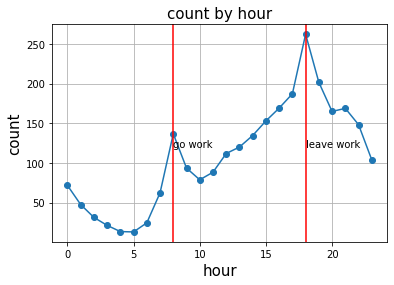

In [113]:
plt.plot(train_data.groupby('hour').mean()['count'], 'o-')
plt.grid()

plt.title('count by hour', fontsize = 15)
plt.xlabel('hour', fontsize = 15)
plt.ylabel('count', fontsize = 15)
plt.axvline(8, color='r')
plt.axvline(18, color='r')
plt.text(8, 120, 'go work', fontsize = 10)
plt.text(18, 120, 'leave work', fontsize = 10)

plt.show()


다른 변수들도 count와의 관계를 알아 보기위해 산점도를 찍어보았다. 정비례로 증가하는 변수들도 있지만 반비례 관계인 변수들도 확인할 수 있다.

[Text(0, 0.5, 'count'),
 Text(0.5, 0, 'hour_bef_humidity'),
 Text(0.5, 1.0, 'count by hour_bef_humidity')]

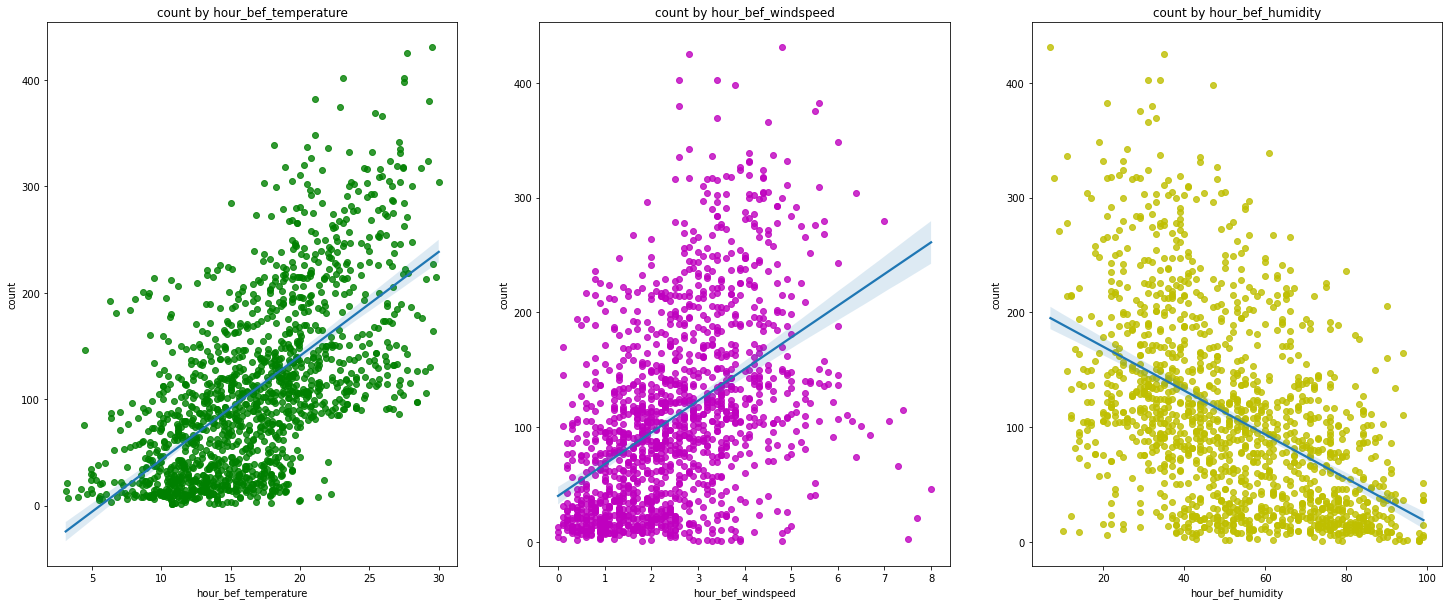

In [114]:
figure, ((ax1,ax2,ax3)) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(25,10)
sns.regplot(data=train_data, x='hour_bef_temperature', y='count', scatter_kws={'color': 'g'}, ax=ax1)
sns.regplot(data=train_data, x='hour_bef_windspeed', y='count', scatter_kws={'color':'m'}, ax=ax2)
sns.regplot(data=train_data, x='hour_bef_humidity', y='count',scatter_kws={'color':'y'},ax=ax3)

ax1.set(xlabel='hour_bef_temperature',ylabel='count', title='count by hour_bef_temperature')
ax2.set(xlabel='hour_bef_windspeed',ylabel='count', title='count by hour_bef_windspeed')
ax3.set(xlabel='hour_bef_humidity',ylabel='count', title='count by hour_bef_humidity')

[Text(0, 0.5, 'count'),
 Text(0.5, 0, 'hour_bef_ozone'),
 Text(0.5, 1.0, 'count by hour_bef_ozone')]

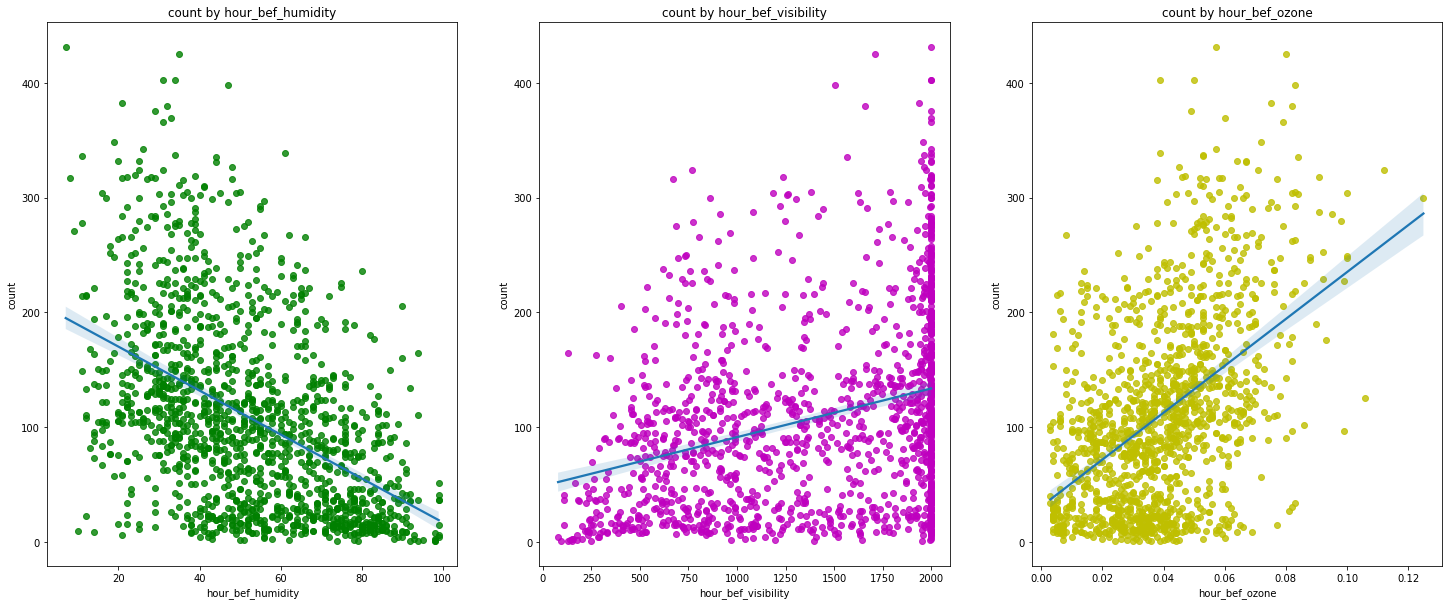

In [115]:
figure, ((ax1,ax2,ax3)) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(25,10)
sns.regplot(data=train_data, x='hour_bef_humidity', y='count', scatter_kws={'color': 'g'}, ax=ax1)
sns.regplot(data=train_data, x='hour_bef_visibility', y='count', scatter_kws={'color':'m'}, ax=ax2)
sns.regplot(data=train_data, x='hour_bef_ozone', y='count',scatter_kws={'color':'y'},ax=ax3)


ax1.set(xlabel='hour_bef_humidity',ylabel='count', title='count by hour_bef_humidity')
ax2.set(xlabel='hour_bef_visibility',ylabel='count', title='count by hour_bef_visibility')
ax3.set(xlabel='hour_bef_ozone',ylabel='count', title='count by hour_bef_ozone')


모든 변수를 일일이 그려보기보단 상관관계를 확인해보는 것이 효율적이다. 
또한 그래프만 봐서는 상관관계가 어느 정도인지 파악하기 힘들기 때문에 수치 값으로 나타내보겠다. 
상관계수는 -1 ~ 1 사이의 값을 지니는데 보통 절대값이 0.4이상이면 두개의 변수간에 상관성이 있다고 볼 수 있다.
상관관계는 인과관계가 아니므로 해석에 유의해야 한다.
머신러닝 모델을 만들 때 쓸 변수를 찾기 위해 상관계수를 확인해서 채택해 보겠다.  
찾을 것이 count이기 때문에 count와 상관계수 높은 변수를 찾아보면 hour, hour_bef_temperature, hour_bef_windspeed, hour_bef_humidity, hour_bef_ozone 정도가 높다고 볼 수 있다.

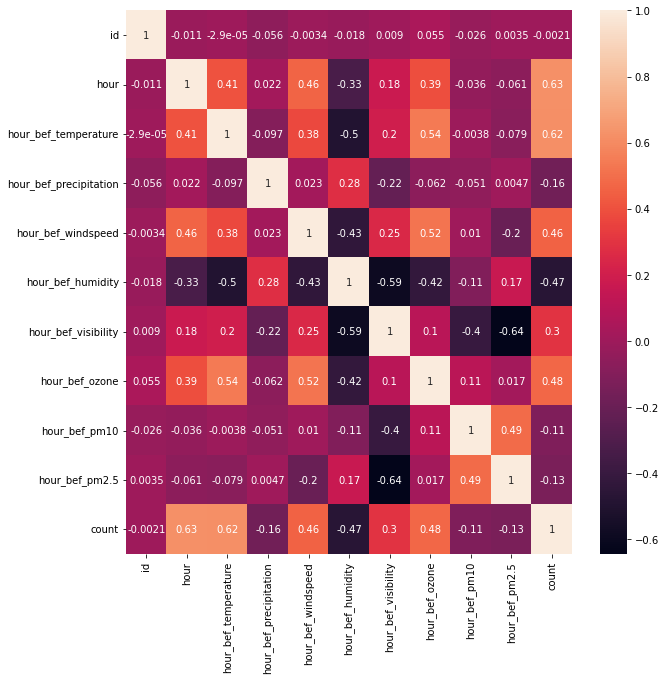

In [116]:
plt.figure(figsize=(10,10))
sns.heatmap(train_data.corr(), annot=True)
plt.show()


결측값들을 처리한다. 처리하기 전에 결측값 상태를 확인해보고 결측값 처리 후 상태도 확인해본다

In [117]:
print(train_data.isna().sum())
print(train_data[train_data['hour_bef_ozone'].isna()]['hour'])
print(train_data.groupby('hour').mean()['hour_bef_ozone'])

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64
14       1
44      17
46       1
84       1
122     16
        ..
1283     1
1322     1
1329     1
1361     1
1391     1
Name: hour, Length: 76, dtype: int64
hour
0     0.033763
1          NaN
2     0.030492
3     0.031213
4     0.031984
5     0.031623
6     0.029317
7     0.025300
8     0.021197
9     0.021492
10    0.025167
11    0.030367
12    0.036817
13    0.045203
14    0.053344
15    0.057400
16    0.060579
17    0.060362
18    0.058508
19    0.053967
20    0.048279
21    0.043517
22    0.038066
23    0.035148
Name: hour_bef_ozone, dtype: float64


In [118]:
null_remover_by_hour('hour_bef_temperature', train_data)
null_remover_by_hour('hour_bef_windspeed', train_data)
null_remover_by_hour('hour_bef_temperature', test_data)
null_remover_by_hour('hour_bef_windspeed', test_data)
null_remover_by_hour('hour_bef_humidity', train_data)
null_remover_by_hour('hour_bef_humidity', test_data)
train_data['hour_bef_ozone'].fillna(0.0321275, inplace=True)

train_data.interpolate(inplace=True)
test_data.fillna(0, inplace=True)


결측값 확인 결과 잘 처리 된 것을 확인할 수 있다.

In [119]:
print(train_data.isna().sum())
print(train_data[train_data['hour_bef_ozone'].isna()]['hour'])
print(train_data.groupby('hour').mean()['hour_bef_ozone'])

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
count                     0
dtype: int64
Series([], Name: hour, dtype: int64)
hour
0     0.033735
1     0.032128
2     0.030492
3     0.031213
4     0.031984
5     0.031623
6     0.029363
7     0.025412
8     0.021197
9     0.021492
10    0.025281
11    0.030396
12    0.036740
13    0.044985
14    0.053344
15    0.056986
16    0.059156
17    0.059421
18    0.057644
19    0.053967
20    0.048279
21    0.043517
22    0.038066
23    0.035148
Name: hour_bef_ozone, dtype: float64


In [120]:
#결측값 확인
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1459 non-null   float64
 3   hour_bef_precipitation  1459 non-null   float64
 4   hour_bef_windspeed      1459 non-null   float64
 5   hour_bef_humidity       1459 non-null   float64
 6   hour_bef_visibility     1459 non-null   float64
 7   hour_bef_ozone          1459 non-null   float64
 8   hour_bef_pm10           1459 non-null   float64
 9   hour_bef_pm2.5          1459 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


In [121]:
#결측값 확인
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1459 non-null   float64
 3   hour_bef_precipitation  1459 non-null   float64
 4   hour_bef_windspeed      1459 non-null   float64
 5   hour_bef_humidity       1459 non-null   float64
 6   hour_bef_visibility     1459 non-null   float64
 7   hour_bef_ozone          1459 non-null   float64
 8   hour_bef_pm10           1459 non-null   float64
 9   hour_bef_pm2.5          1459 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


랜덤포레스트를 이용하여 머신러닝 모델을 만든다. 디시전트리로는 ['hour','hour_bef_temperature','hour_bef_windspeed','hour_bef_humidity','hour_bef_ozone'] 이 변수들을 활용했고 모델 4가지를 만들어보았다. 각각의 모델은 n_estimators, max_depth 등의 하이퍼 파라미터들을 조정해 주었다. train 데이터를 이용해 모델을 만들고 rmse 로 정확도가 가장 높은 모델을 찾아서 그 모델을 이용해 test데이터의 대여량을 예측한다. 

In [52]:
features = ['hour','hour_bef_temperature','hour_bef_windspeed','hour_bef_humidity','hour_bef_ozone']
X_train = train_data[features]
y_train = train_data['count']
X_test = test_data[features]



model100 = RandomForestRegressor(n_estimators=100, random_state=0) 
model100_5 = RandomForestRegressor(n_estimators=100,max_depth=5, random_state=0)
model200 = RandomForestRegressor(n_estimators=200)
model1000 = RandomForestRegressor(criterion = 'squared_error',n_estimators=1000, n_jobs=-1, random_state=0)

#학습
model100.fit(X_train, y_train)
model100_5.fit(X_train, y_train)
model200.fit(X_train, y_train)
model1000.fit(X_train, y_train)

#예측
ypred1 = model100.predict(X_train)
ypred2 = model100_5.predict(X_train)
ypred3 = model200.predict(X_train)
ypred4 = model1000.predict(X_train)



오차값을 구하는 코드이다.

In [66]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)

    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)

    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)

    # 평균을 낸다.
    mean_difference = difference.mean()

    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)

    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

model100을 이용하여 예측한 데이터이다. 산점도와 오차값을 나타내어 보았다. 

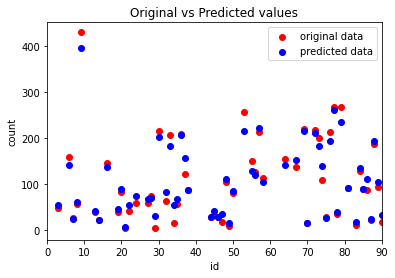

0.3146604808033627

In [67]:
# predict our car price 
train_backup['count']=ypred1
plt.scatter(train_data['id'],train_data['count'],label = "original data",color ="red")
plt.scatter(train_backup['id'],train_backup['count'],label = "predicted data",color ="blue")

plt.legend()
plt.xlim([0, 90]) 

plt.xlabel("id")
plt.ylabel("count")
plt.title("Original vs Predicted values")
plt.show()

rmsle(train_backup['count'],train_data['count'])


model100_5을 이용하여 예측한 데이터이다. 산점도와 오차값을 나타내어 보았다. 

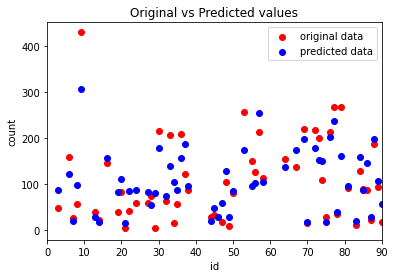

0.538262932291687

In [68]:
# predict our car price 
train_backup['count']=ypred2
plt.scatter(train_data['id'],train_data['count'],label = "original data",color ="red")
plt.scatter(train_backup['id'],train_backup['count'],label = "predicted data",color ="blue")

plt.legend()
plt.xlim([0, 90]) 

plt.xlabel("id")
plt.ylabel("count")
plt.title("Original vs Predicted values")
plt.show()

rmsle(train_backup['count'],train_data['count'])


model200을 이용하여 예측한 데이터이다. 산점도와 오차값을 나타내어 보았다. 

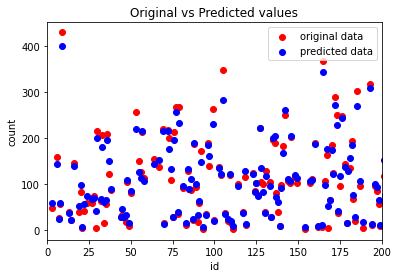

0.31127423244735164

In [69]:
# predict our car price 
train_backup['count']=ypred3
plt.scatter(train_data['id'],train_data['count'],label = "original data",color ="red")
plt.scatter(train_backup['id'],train_backup['count'],label = "predicted data",color ="blue")

plt.legend()
plt.xlim([0, 200]) 

plt.xlabel("id")
plt.ylabel("count")
plt.title("Original vs Predicted values")
plt.show()


rmsle(train_backup['count'],train_data['count'])


model1000을 이용하여 예측한 데이터이다. 산점도와 오차값을 나타내어 보았다. 

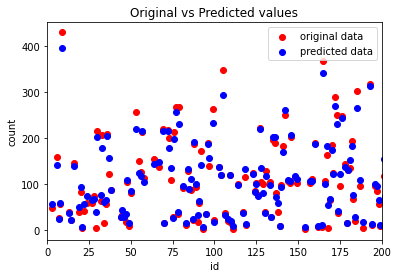

0.3133526395783024

In [70]:
# predict our car price 
train_backup['count']=ypred4
plt.scatter(train_data['id'],train_data['count'],label = "original data",color ="red")
plt.scatter(train_backup['id'],train_backup['count'],label = "predicted data",color ="blue")

plt.legend()
plt.xlim([0, 200]) 

plt.xlabel("id")
plt.ylabel("count")
plt.title("Original vs Predicted values")
plt.show()


rmsle(train_backup['count'],train_data['count'])


rmse가 가장 적게 나온 pred3이 정확도가 가장 높은 것을 확인할 수 있다. 
pred3은 n_estimators=200 으로 랜덤 포레스트를 적용한 것이다. 이 방법으로 test 데이터의 정보를 바탕으로 1시간 후의 따릉이 대여량을 예측한다.


In [79]:
model200.fit(X_train, y_train)

ypred3 = model200.predict(X_test)

result['count'] = ypred3
result.to_csv('model200.csv', index = False)

result

,id,count
0,0,87.555
1,1,233.395
2,2,95.195
3,4,28.475
4,5,71.080
...,...,...
710,2148,65.335
711,2149,65.130
712,2165,120.135
713,2166,141.370
